In [35]:
import numpy as np
import pandas as pd
from utils import *

In [36]:
df = load_from_csv('/Users/shamanthk/Documents/iomics/DoWhy-workflow/data/lung_cancer.csv')
df = df.dropna()
df.drop_duplicates(inplace=True)
labels = list(df.columns)
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO


In [37]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

cols = df.columns[(df == 1).any() | (df == 2).any()]
df[cols] = df[cols].replace({1: 0, 2: 1})

df['LUNG_CANCER']=encoder.fit_transform(df['LUNG_CANCER'])
df['GENDER']=encoder.fit_transform(df['GENDER'])
df.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,0,1,1,0,0,1,0,1,1,1,1,1,1,1
1,1,74,1,0,0,0,1,1,1,0,0,0,1,1,1,1
2,0,59,0,0,0,1,0,1,0,1,0,1,1,0,1,0
3,1,63,1,1,1,0,0,0,0,0,1,0,0,1,1,0
4,0,63,0,1,0,0,0,0,0,1,0,1,1,0,0,0


In [38]:
import dowhy

In [39]:
data = df.to_numpy()
data

array([[ 1, 69,  0, ...,  1,  1,  1],
       [ 1, 74,  1, ...,  1,  1,  1],
       [ 0, 59,  0, ...,  0,  1,  0],
       ...,
       [ 1, 55,  1, ...,  0,  1,  0],
       [ 1, 46,  0, ...,  1,  1,  0],
       [ 1, 60,  0, ...,  1,  1,  1]])

In [40]:
from dowhy import CausalModel

model_est=CausalModel(
        data = df,
        treatment='SMOKING',
        outcome='LUNG_CANCER',
        graph='lingam.gml')

In [41]:
from dowhy import gcm

In [42]:
predicted_graph_lingam = nx.read_gml('lingam.gml')

In [73]:
causal_model = gcm.InvertibleStructuralCausalModel(predicted_graph_lingam)
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, df, override_models=True, quality=gcm.auto.AssignmentQuality.GOOD)

In [74]:
print(auto_assignment_summary)

When using this auto assignment function, the given data is used to automatically assign a causal mechanism to each node. Note that causal mechanisms can also be customized and assigned manually.
The following types of causal mechanisms are considered for the automatic selection:

If root node:
An empirical distribution, i.e., the distribution is represented by randomly sampling from the provided data. This provides a flexible and non-parametric way to model the marginal distribution and is valid for all types of data modalities.

If non-root node and the data is continuous:
Additive Noise Models (ANM) of the form X_i = f(PA_i) + N_i, where PA_i are the parents of X_i and the unobserved noise N_i is assumed to be independent of PA_i.To select the best model for f, different regression models are evaluated and the model with the smallest mean squared error is selected.Note that minimizing the mean squared error here is equivalent to selecting the best choice of an ANM.

If non-root node

In [75]:
gcm.fit(causal_model, df)

Fitting causal mechanism of node LUNG_CANCER: 100%|██████████| 16/16 [00:00<00:00, 18.37it/s]          


In [76]:
counterfactual_data1 = gcm.counterfactual_samples(
    causal_model,
    {'SMOKING': lambda x: 1},
    df
)

counterfactual_data2 = gcm.counterfactual_samples(
    causal_model,
    {'SMOKING': lambda x: 0},
    df
)

In [65]:
counterfactual_data1

,GENDER,SMOKING,WHEEZING,ANXIETY,CHRONIC DISEASE,YELLOW_FINGERS,FATIGUE,ALLERGY,PEER_PRESSURE,ALCOHOL CONSUMING,COUGHING,SWALLOWING DIFFICULTY,AGE,SHORTNESS OF BREATH,CHEST PAIN,LUNG_CANCER
0,0,1,0,1,1,1,1,0,1,0,0,1,66,1,0,1
1,1,1,1,-1,0,0,2,1,1,1,1,1,64,1,2,1
2,0,1,0,1,1,1,1,0,1,-1,0,1,61,1,0,1
3,1,1,1,-1,0,0,1,1,0,1,1,0,67,1,1,1
4,1,1,1,0,0,0,2,1,0,1,1,0,53,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,0,2,1,1,1,0,0,0,0,0,61,1,0,1
996,0,1,0,0,1,0,2,1,1,0,2,1,1248629604,1,0,1
997,1,1,0,0,0,1,1,1,0,1,2,0,1248629618,1,1,1
998,1,1,1,0,1,0,1,2,0,1,1,0,65,1,0,1


In [79]:
counterfactual_data2

,GENDER,SMOKING,WHEEZING,ANXIETY,CHRONIC DISEASE,YELLOW_FINGERS,FATIGUE,ALLERGY,PEER_PRESSURE,ALCOHOL CONSUMING,COUGHING,SWALLOWING DIFFICULTY,AGE,SHORTNESS OF BREATH,CHEST PAIN,LUNG_CANCER
0,1,0,1,1,0,1,1,0,0,1,1,1,69,1,1,1
1,1,0,0,0,2,0,1,1,0,0,0,1,74,1,1,1
2,0,0,1,0,0,0,1,0,1,0,1,0,59,1,1,0
3,1,0,0,1,1,1,0,1,0,2,0,1,63,0,1,0
4,0,0,1,0,0,1,0,0,0,0,1,0,63,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,0,0,1,1,0,1,0,1,1,0,1,1,59,0,0,1
272,0,0,0,-1,1,0,1,1,0,0,0,0,59,1,0,0
273,1,0,0,0,1,0,1,1,0,0,0,0,55,1,1,1
274,1,0,0,1,0,1,0,0,0,0,0,1,46,0,1,0


In [67]:
counterfactual_data1.dtypes

GENDER                   int64
SMOKING                  int64
WHEEZING                 int64
ANXIETY                  int32
CHRONIC DISEASE          int32
YELLOW_FINGERS           int32
FATIGUE                  int32
ALLERGY                  int32
PEER_PRESSURE            int32
ALCOHOL CONSUMING        int32
COUGHING                 int32
SWALLOWING DIFFICULTY    int32
AGE                      int32
SHORTNESS OF BREATH      int32
CHEST PAIN               int32
LUNG_CANCER              int32
dtype: object

In [80]:
counterfactual_data1['LUNG_CANCER'].value_counts()

1    238
0     35
2      3
Name: LUNG_CANCER, dtype: int64

In [81]:
counterfactual_data2['LUNG_CANCER'].value_counts()

1    240
0     36
Name: LUNG_CANCER, dtype: int64

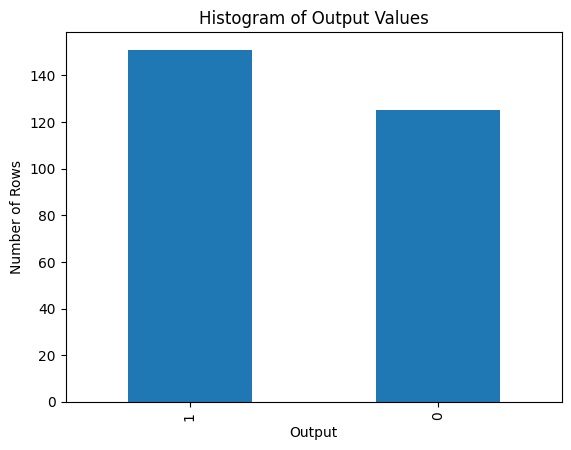

In [82]:
import matplotlib.pyplot as plt

counterfactual_data1['WHEEZING'].value_counts().plot(kind='bar')
plt.xlabel('Output')
plt.ylabel('Number of Rows')
plt.title('Histogram of Output Values')
plt.show()

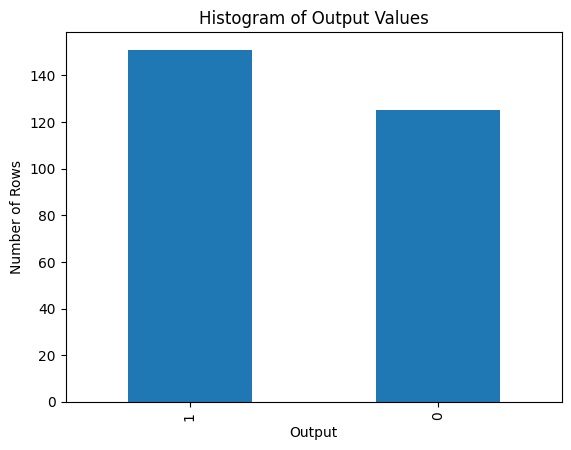

In [83]:
counterfactual_data2['WHEEZING'].value_counts().plot(kind='bar')
plt.xlabel('Output')
plt.ylabel('Number of Rows')
plt.title('Histogram of Output Values')
plt.show()